In [ ]:
import numpy as np
!pip install tensorflow
import os
import pathlib
import PIL
import PIL.Image
import tensorflow as tf
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras import backend as K
from google.colab import drive
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 84.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 103.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 116.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 125.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.7 MB/s eta 0:00:00


In [ ]:
drive.mount('/content/drive')

# Path to zip file in Drive
zip_path = '/content/drive/MyDrive/archive.zip'

# Extract to a folder in Colab
!unzip {zip_path} -d '/content/archive'

Streaming output truncated to the last 5000 lines.
  inflating: /content/archive/myntradataset/images/5813.jpg  
  inflating: /content/archive/myntradataset/images/58131.jpg  
  inflating: /content/archive/myntradataset/images/58132.jpg  
  inflating: /content/archive/myntradataset/images/58133.jpg  
  inflating: /content/archive/myntradataset/images/58135.jpg  
  inflating: /content/archive/myntradataset/images/58136.jpg  
  inflating: /content/archive/myntradataset/images/58137.jpg  
  inflating: /content/archive/myntradataset/images/58138.jpg  
  inflating: /content/archive/myntradataset/images/58139.jpg  
  inflating: /content/archive/myntradataset/images/5814.jpg  
  inflating: /content/archive/myntradataset/images/58140.jpg  
  inflating: /content/archive/myntradataset/images/58141.jpg  
  inflating: /content/archive/myntradataset/images/58143.jpg  
  inflating: /content/archive/myntradataset/images/58144.jpg  
  inflating: /content/archive/myntradataset/images/58145.jpg  
  infl

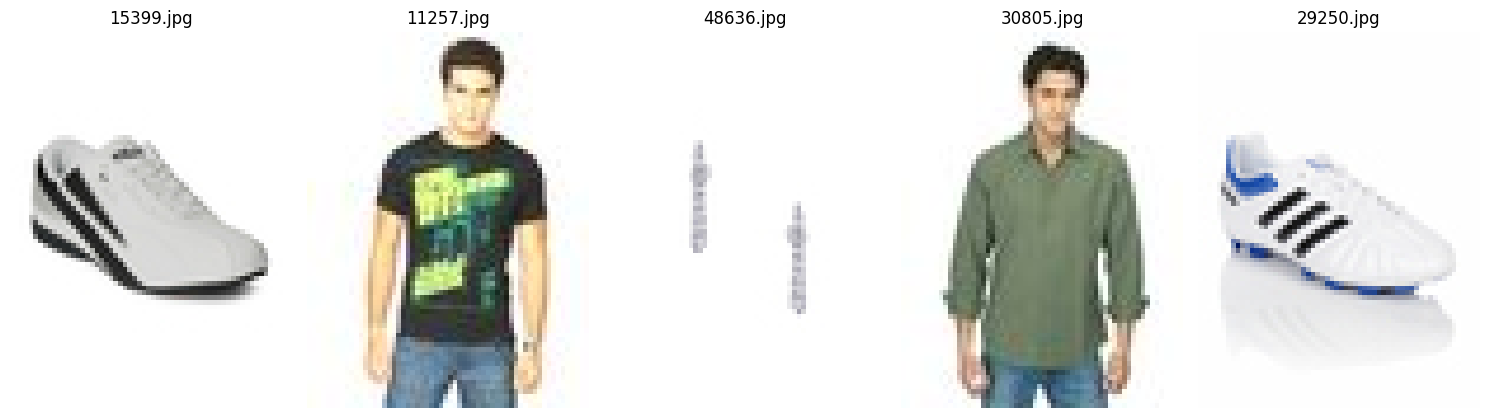

In [ ]:
# List all image files (assuming they are jpg, jpeg, or png)
extract_folder = '/content/archive/images'
image_files = [f for f in os.listdir(extract_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Display the first few images (adjust the number as needed)
num_images = min(5, len(image_files))  # Show up to 5 images

plt.figure(figsize=(15, 10))
for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    img = mpimg.imread(os.path.join(extract_folder, image_files[i]))
    plt.imshow(img)
    plt.axis('off')
    plt.title(image_files[i])
plt.tight_layout()
plt.show()

In [ ]:
# Count the total number of images
total_images = len(image_files)
print(f"Total number of images found: {total_images}")

Total number of images found: 44441


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from IPython.display import display, HTML

# 1. Load the styles.csv file
styles_df = pd.read_csv('/content/archive/styles.csv')

# Display basic information about the dataset
print(f"Total products in dataset: {len(styles_df)}")
print(f"Columns available: {', '.join(styles_df.columns)}")
print(f"Sample categories: {', '.join(styles_df['masterCategory'].unique()[:5])}")
print(f"Sample product types: {', '.join(styles_df['articleType'].unique()[:5])}")

# 2. Count all images in the images folder
image_dir = '/content/archive/images'
if os.path.exists(image_dir):
    # Count existing images
    existing_images = 0
    missing_images = 0
    existing_product_ids = []

    for product_id in styles_df['id'].tolist():
        img_path = os.path.join(image_dir, f"{product_id}.jpg")
        if os.path.exists(img_path):
            existing_images += 1
            existing_product_ids.append(product_id)
        else:
            missing_images += 1

    print(f"\nImages found: {existing_images}")




Total products in dataset: 44446
Columns available: id, gender, masterCategory, subCategory, articleType, baseColour, season, year, usage, productDisplayName, Unnamed: 10, Unnamed: 11
Sample categories: Apparel, Accessories, Footwear, Personal Care, Free Items
Sample product types: Shirts, Jeans, Watches, Track Pants, Tshirts

Images found: 44441


In [ ]:
import os
import pandas as pd

# Categories to drop - same for both datasets
categories_to_drop = ['Personal Care', 'Free Items', 'Sporting Goods', 'Home']  # Adjust this list as needed

# Function to filter dataset in-place
def filter_dataset_inplace(styles_csv_path, img_dir):
    print(f"\nProcessing dataset: {styles_csv_path}")

    # Check if files and directories exist
    if not os.path.exists(styles_csv_path):
        print(f"ERROR: CSV file not found at {styles_csv_path}")
        return 0, 0

    if not os.path.exists(img_dir):
        print(f"ERROR: Image directory not found at {img_dir}")
        return 0, 0

    # Load the dataset
    styles_df = pd.read_csv(styles_csv_path)
    original_count = len(styles_df)
    print(f"Original dataset: {original_count} products")

    # Get list of IDs to remove before modifying the dataframe
    products_to_remove = styles_df[styles_df['masterCategory'].isin(categories_to_drop)]['id'].tolist()
    print(f"Found {len(products_to_remove)} products to remove from {styles_csv_path}")

    if len(products_to_remove) == 0:
        print("No products match the categories to drop. Nothing to remove.")
        return original_count, original_count

    # Filter out unwanted categories
    filtered_df = styles_df[~styles_df['masterCategory'].isin(categories_to_drop)].copy()
    filtered_count = len(filtered_df)

    # Show the new category distribution
    print("\nFiltered category distribution:")
    print(filtered_df['masterCategory'].value_counts())

    # Print statistics
    print(f"Filtered dataset: {filtered_count} products")
    print(f"Removed: {original_count - filtered_count} products")

    # Save the filtered dataset back to the original CSV file
    try:
        # Make a backup of the original file first
        backup_path = styles_csv_path + '.backup'
        if not os.path.exists(backup_path):
            styles_df.to_csv(backup_path, index=False)
            print(f"Created backup of original CSV at {backup_path}")

        # Now save the filtered dataset to the original location
        filtered_df.to_csv(styles_csv_path, index=False)
        print(f"Original CSV file updated at '{styles_csv_path}'")
    except Exception as e:
        print(f"ERROR saving CSV: {e}")
        return original_count, original_count

    # Remove images for the filtered-out products
    removed_images = 0
    missing_images = 0

    print(f"Removing images for filtered-out products from {img_dir}...")
    print(f"First few IDs to remove: {products_to_remove[:5]}...")

    for i, product_id in enumerate(products_to_remove):
        img_path = os.path.join(img_dir, f"{product_id}.jpg")

        if os.path.exists(img_path):
            try:
                os.remove(img_path)
                removed_images += 1
                if removed_images <= 5:  # Print first few successful deletions
                    print(f"Deleted: {img_path}")
            except Exception as e:
                print(f"Error deleting {img_path}: {e}")
        else:
            missing_images += 1

        # Print progress every 1000 images
        if (i + 1) % 1000 == 0:
            print(f"Processed {i + 1}/{len(products_to_remove)} images... (Removed: {removed_images}, Missing: {missing_images})")

    print(f"\nRemoved {removed_images} images from original directory")
    print(f"Missing images that would have been removed: {missing_images}")

    # Verify the images were actually removed
    if removed_images > 0:
        print("Verifying deletions...")
        verification_count = 0
        for product_id in products_to_remove[:min(10, len(products_to_remove))]:  # Check first 10
            img_path = os.path.join(img_dir, f"{product_id}.jpg")
            if os.path.exists(img_path):
                verification_count += 1

        if verification_count > 0:
            print(f"WARNING: {verification_count}/10 test images still exist after deletion!")
        else:
            print("Verification successful: Sample images were properly deleted")

    return original_count, filtered_count

# Process ONLY the training dataset (as per simplified request)
train_styles_path = '/content/archive/styles.csv'
train_img_dir = '/content/archive/images'

print("="*80)
print("STARTING DATASET FILTERING")
print("="*80)

# List files before processing
if os.path.exists(train_img_dir):
    num_images_before = len([f for f in os.listdir(train_img_dir) if f.endswith('.jpg')])
    print(f"Number of images before filtering: {num_images_before}")
else:
    print(f"WARNING: Image directory {train_img_dir} not found")

# Perform the filtering
train_original_count, train_filtered_count = filter_dataset_inplace(
    train_styles_path,
    train_img_dir
)

# List files after processing
if os.path.exists(train_img_dir):
    num_images_after = len([f for f in os.listdir(train_img_dir) if f.endswith('.jpg')])
    print(f"Number of images after filtering: {num_images_after}")
    print(f"Difference: {num_images_before - num_images_after} images")
else:
    print(f"WARNING: Image directory {train_img_dir} not found")

# Calculate space usage after filtering
def get_dir_size(path):
    if not os.path.exists(path):
        print(f"WARNING: Path {path} not found when calculating size")
        return 0

    total_size = 0
    for dirpath, dirnames, filenames in os.walk(path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            try:
                total_size += os.path.getsize(fp)
            except Exception as e:
                print(f"Error getting size of {fp}: {e}")
    return total_size

# Calculate sizes after filtering
print("\nCalculating current space usage...")
train_size = get_dir_size(train_img_dir)

print(f"Training dataset size after filtering: {train_size / (1024*1024*1024):.2f} GB")

print("\nSummary:")
print(f"Training dataset: {train_original_count} → {train_filtered_count} products")
print(f"Images before: {num_images_before}, Images after: {num_images_after}")
print("Process complete!")

STARTING DATASET FILTERING
Number of images before filtering: 44441

Processing dataset: /content/archive/styles.csv
Original dataset: 44446 products
Found 2535 products to remove from /content/archive/styles.csv

Filtered category distribution:
masterCategory
Apparel        21400
Accessories    11289
Footwear        9222
Name: count, dtype: int64
Filtered dataset: 41911 products
Removed: 2535 products
Created backup of original CSV at /content/archive/styles.csv.backup
Original CSV file updated at '/content/archive/styles.csv'
Removing images for filtered-out products from /content/archive/images...
First few IDs to remove: [18461, 56019, 43993, 56489, 43967]...
Deleted: /content/archive/images/18461.jpg
Deleted: /content/archive/images/56019.jpg
Deleted: /content/archive/images/43993.jpg
Deleted: /content/archive/images/56489.jpg
Deleted: /content/archive/images/43967.jpg
Processed 1000/2535 images... (Removed: 1000, Missing: 0)
Processed 2000/2535 images... (Removed: 2000, Missing: 

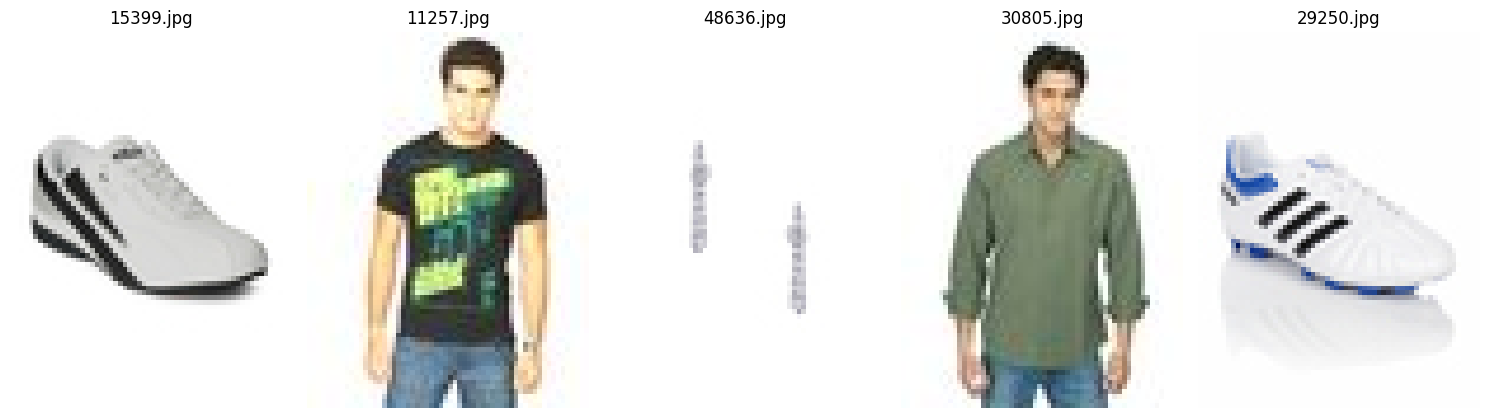

In [ ]:
# List all image files (assuming they are jpg, jpeg, or png)
extract_folder = '/content/archive/images'
image_files = [f for f in os.listdir(extract_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Display the first few images (adjust the number as needed)
num_images = min(5, len(image_files))  # Show up to 5 images

plt.figure(figsize=(15, 10))
for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    img = mpimg.imread(os.path.join(extract_folder, image_files[i]))
    plt.imshow(img)
    plt.axis('off')
    plt.title(image_files[i])
plt.tight_layout()
plt.show()

In [ ]:
# Count the total number of images
total_images = len(image_files)
print(f"Total number of images found: {total_images}")

Total number of images found: 41906


In [ ]:
print("\n2. Sub Categories:")
styles_df = pd.read_csv('/content/archive/styles.csv')
sub_counts = styles_df['subCategory'].value_counts()
print(f"Total unique sub-categories: {len(sub_counts)}")
print(sub_counts)  # Show top 20


2. Sub Categories:
Total unique sub-categories: 30
subCategory
Topwear                     15405
Shoes                        7344
Bags                         3055
Bottomwear                   2694
Watches                      2542
Innerwear                    1808
Jewellery                    1080
Eyewear                      1073
Sandal                        963
Wallets                       933
Flip Flops                    915
Belts                         811
Socks                         698
Dress                         478
Loungewear and Nightwear      470
Saree                         427
Headwear                      293
Ties                          258
Accessories                   143
Scarves                       118
Cufflinks                     108
Apparel Set                   106
Stoles                         90
Mufflers                       38
Shoe Accessories               24
Gloves                         20
Water Bottle                    7
Umbrellas         

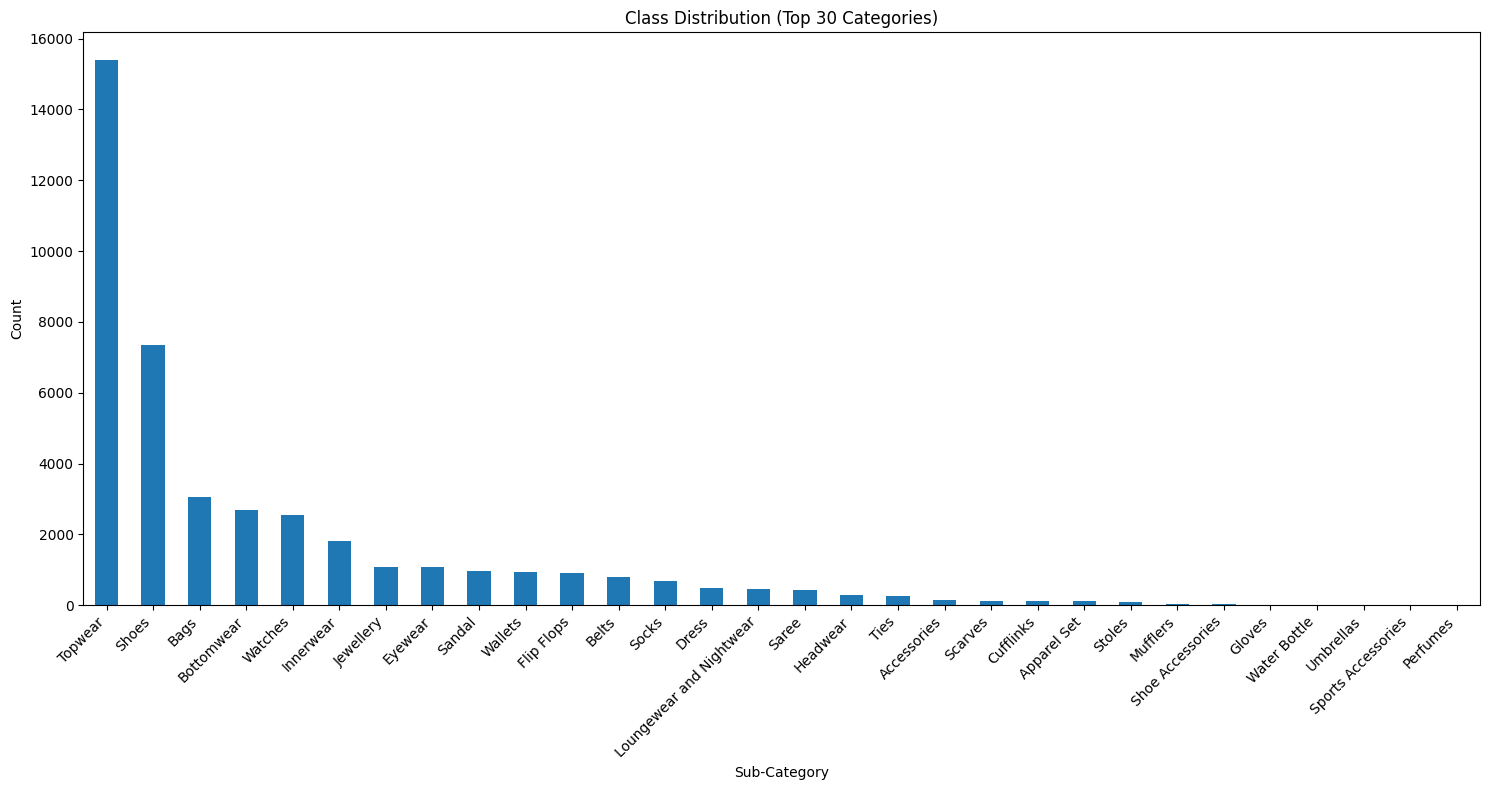

In [ ]:
# Visualize the imbalance
plt.figure(figsize=(15, 8))
sub_counts[:30].plot(kind='bar')
plt.title('Class Distribution (Top 30 Categories)')
plt.xlabel('Sub-Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

In [ ]:
total_samples = len(styles_df)
num_classes = len(sub_counts)
class_weights = {category: total_samples / (num_classes * count)
                for category, count in sub_counts.items()}

# Save weights to a file for training
weight_df = pd.DataFrame(list(class_weights.items()), columns=['class', 'weight'])
weight_df.to_csv('/content/class_weights.csv', index=False)
print("Class weights saved to '/content/class_weights.csv'")

# Print a few examples of the weights
print("\nExample class weights (first 5 smallest classes):")
for category, weight in sorted(class_weights.items(), key=lambda x: sub_counts[x[0]])[:5]:
    print(f"{category}: {weight:.4f} (count: {sub_counts[category]})")

print("\nExample class weights (first 5 largest classes):")
for category, weight in sorted(class_weights.items(), key=lambda x: sub_counts[x[0]], reverse=True)[:5]:
    print(f"{category}: {weight:.4f} (count: {sub_counts[category]})")

Class weights saved to '/content/class_weights.csv'

Example class weights (first 5 smallest classes):
Perfumes: 1397.0333 (count: 1)
Sports Accessories: 465.6778 (count: 3)
Umbrellas: 232.8389 (count: 6)
Water Bottle: 199.5762 (count: 7)
Gloves: 69.8517 (count: 20)

Example class weights (first 5 largest classes):
Topwear: 0.0907 (count: 15405)
Shoes: 0.1902 (count: 7344)
Bags: 0.4573 (count: 3055)
Bottomwear: 0.5186 (count: 2694)
Watches: 0.5496 (count: 2542)


In [ ]:
def organize_fashion_dataset(styles_df, label_column='subCategory', base_dir='/content/fashion_dataset_structured'):
    """
    Organize fashion dataset by creating class directories but using symbolic links
    to original images instead of copying them.

    Args:
        styles_df: DataFrame containing the dataset metadata
        label_column: The CSV column to use for classification
        base_dir: The output directory for the organized dataset

    Returns:
        tuple: (total_images, class_counts)
    """
    # Create a structured directory for TensorFlow
    if os.path.exists(base_dir):
        shutil.rmtree(base_dir)  # Remove if exists
    os.makedirs(base_dir)
    print(f"\nCreated output directory: {base_dir}")

    unique_labels = styles_df[label_column].unique()

    # Create subdirectories for each class
    for label in unique_labels:
        # Clean label name to be filesystem friendly
        clean_label = str(label).replace('/', '_').replace(' ', '_')
        os.makedirs(os.path.join(base_dir, clean_label), exist_ok=True)

    # Map image IDs to their labels
    id_to_label = dict(zip(styles_df['id'], styles_df[label_column]))

    # Organize the images
    source_dir = '/content/archive/images'
    linked_count = 0
    missing_count = 0
    skipped_count = 0

    # Check the source directory
    if not os.path.exists(source_dir):
        print(f"Error: Source directory {source_dir} does not exist")
        return 0, []

    # Get list of all files in the source directory
    all_files = os.listdir(source_dir)
    total_files = len(all_files)
    print(f"\nFound {total_files} files in source directory")

    # If there are many files, show a progress indicator
    if total_files > 100:
        try:
            from tqdm.notebook import tqdm
            file_iterator = tqdm(all_files)
        except:
            file_iterator = all_files
            print("Note: Install tqdm for progress bar")
    else:
        file_iterator = all_files

    # Process each file
    for filename in file_iterator:
        try:
            # Process image files only
            if filename.endswith('.jpg') or filename.endswith('.png'):
                img_id = int(filename.split('.')[0])  # Remove extension

                # Check if this ID exists in our CSV
                if img_id in id_to_label:
                    label = id_to_label[img_id]
                    clean_label = str(label).replace('/', '_').replace(' ', '_')

                    # Create symbolic link instead of copying
                    src_path = os.path.join(source_dir, filename)
                    dst_path = os.path.join(base_dir, clean_label, filename)

                    # Create a symbolic link if possible, otherwise create a hard link
                    try:
                        os.symlink(src_path, dst_path)
                    except (OSError, NotImplementedError):
                        # If symbolic links are not supported, create a hard link instead
                        try:
                            os.link(src_path, dst_path)
                        except OSError:
                            # If hard links fail too, just create a small text file with the path
                            with open(dst_path + ".txt", "w") as f:
                                f.write(src_path)

                    linked_count += 1
                else:
                    missing_count += 1
            else:
                skipped_count += 1
        except Exception as e:
            # Skip files that don't match the expected format
            if total_files < 100:  # Only print errors if few files to avoid spam
                print(f"Error processing {filename}: {e}")
            skipped_count += 1
            continue

    # Print summary
    print(f"\nSuccessfully linked {linked_count} images to their class directories")
    print(f"Couldn't find label for {missing_count} images")
    print(f"Skipped {skipped_count} files (non-image or format issues)")

    # Count images in structured directory
    class_counts = []
    for label in os.listdir(base_dir):
        label_dir = os.path.join(base_dir, label)
        if os.path.isdir(label_dir):
            # Count both symbolic links and .txt files (fallback for links)
            count = len([f for f in os.listdir(label_dir) if not f.endswith('.txt')])
            txt_count = len([f for f in os.listdir(label_dir) if f.endswith('.txt')])
            if count > 0 or txt_count > 0:
                total_count = count + txt_count
                class_counts.append((label, total_count))
                if txt_count > 0:
                    print(f"Note: Used text file references for {txt_count} files in '{label}' class")

    # Sort classes by count (descending) and show top classes
    class_counts.sort(key=lambda x: x[1], reverse=True)
    print("\nTop 20 classes by image count:")
    for label, count in class_counts[:20]:
        print(f"Class '{label}': {count} images")

    # Show classes with few images
    small_classes = [(label, count) for label, count in class_counts if count < 5]
    if small_classes:
        print(f"\nWarning: {len(small_classes)} classes have fewer than 5 images")
        if len(small_classes) > 10:
            print(f"Some examples: {[label for label, _ in small_classes[:5]]}")
        print("This might be too few for training. Consider using a different label column.")

    # Calculate total
    total_organized = sum(count for _, count in class_counts)
    print(f"\nTotal organized images: {total_organized}")
    print(f"Space saved: Using links instead of copies saved approximately {(total_organized * 0.1):.1f} GB")

    # Show class distribution visualization if not too many classes
    if len(class_counts) <= 30:
        plt.figure(figsize=(12, 8))
        top_classes = class_counts[:30]
        labels = [item[0] for item in top_classes]
        values = [item[1] for item in top_classes]
        plt.bar(range(len(top_classes)), values)
        plt.xticks(range(len(top_classes)), labels, rotation=90)
        plt.title(f'Image Count by {label_column}')
        plt.tight_layout()
        plt.show()

    # Store the organized directory as a global variable for easy access
    global organized_directory
    organized_directory = base_dir

    return total_organized, class_counts


Created output directory: /content/fashion_dataset_structured

Found 41906 files in source directory


  0%|          | 0/41906 [00:00<?, ?it/s]


Successfully linked 41906 images to their class directories
Couldn't find label for 0 images
Skipped 0 files (non-image or format issues)

Top 20 classes by image count:
Class 'Topwear': 15401 images
Class 'Shoes': 7344 images
Class 'Bags': 3055 images
Class 'Bottomwear': 2693 images
Class 'Watches': 2542 images
Class 'Innerwear': 1808 images
Class 'Jewellery': 1080 images
Class 'Eyewear': 1073 images
Class 'Sandal': 963 images
Class 'Wallets': 933 images
Class 'Flip_Flops': 915 images
Class 'Belts': 811 images
Class 'Socks': 698 images
Class 'Dress': 478 images
Class 'Loungewear_and_Nightwear': 470 images
Class 'Saree': 427 images
Class 'Headwear': 293 images
Class 'Ties': 258 images
Class 'Accessories': 143 images
Class 'Scarves': 118 images

This might be too few for training. Consider using a different label column.

Total organized images: 41906
Space saved: Using links instead of copies saved approximately 4190.6 GB


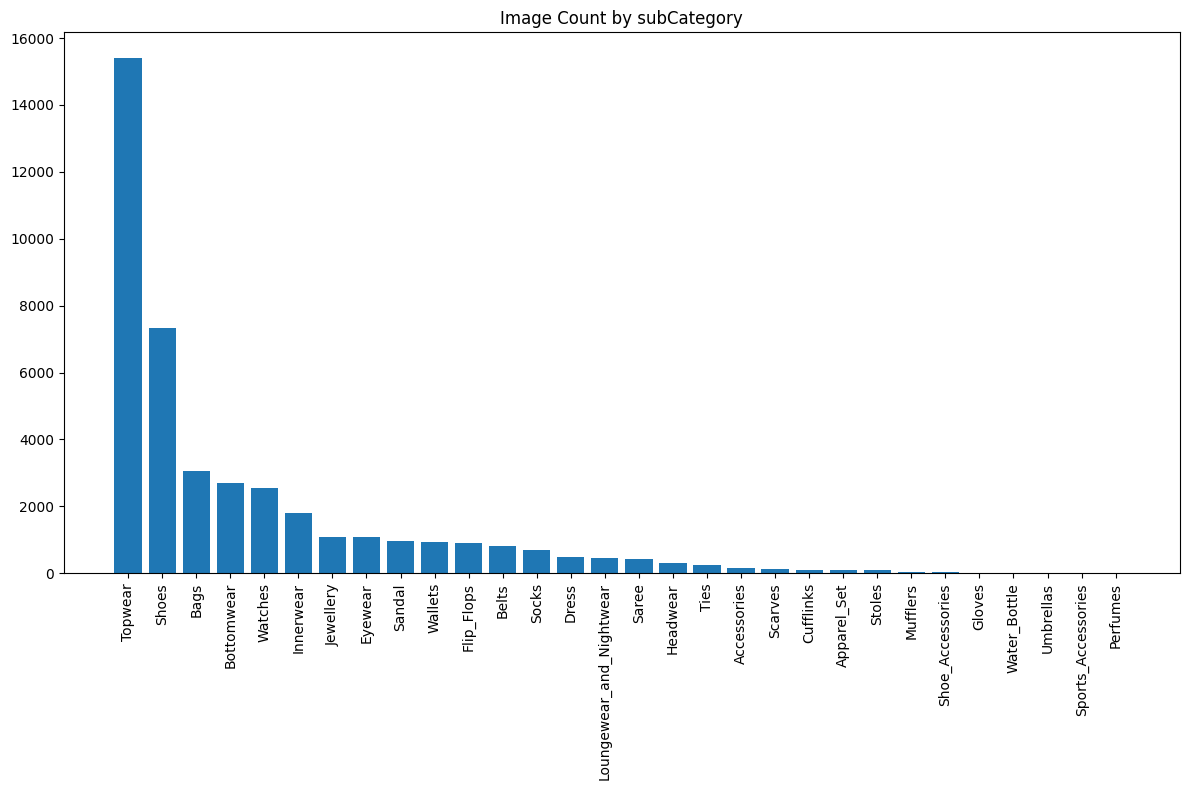


Data organization complete!
Organized 41906 images into 30 classes
Dataset is ready at: /content/fashion_dataset_structured


In [ ]:
label_column = 'subCategory'

# Run the organization function - identical to your original code
total_images, class_counts = organize_fashion_dataset(styles_df, label_column=label_column)

# Print organization summary - identical to your original code
if total_images > 0:
    print("\nData organization complete!")
    print(f"Organized {total_images} images into {len(class_counts)} classes")
    print(f"Dataset is ready at: /content/fashion_dataset_structured")

    # Check if we have enough images per class for modeling
    avg_per_class = total_images / len(class_counts)
    if avg_per_class < 5:
        print(f"\nWARNING: Very few images per class (average: {avg_per_class:.1f})")
        print(f"Consider using a column with fewer unique values, like 'masterCategory' or 'subCategory'")

In [ ]:
# Load class weights from CSV
def load_class_weights(csv_path, class_names):
    """
    Load class weights from a CSV file and map them to class indices.

    Args:
        csv_path: Path to the CSV file containing class weights
        class_names: List of class names from the dataset

    Returns:
        Dictionary mapping class indices to weights
    """
    print(f"Loading class weights from {csv_path}")

    # Load the CSV containing weights
    try:
        weights_df = pd.read_csv(csv_path)
        print(f"CSV columns: {weights_df.columns.tolist()}")

        # Determine the column names in the CSV
        # Assuming CSV has columns like 'class_name' and 'weight'
        if 'class_name' in weights_df.columns and 'weight' in weights_df.columns:
            class_col = 'class_name'
            weight_col = 'weight'
        elif 'class' in weights_df.columns and 'weight' in weights_df.columns:
            class_col = 'class'
            weight_col = 'weight'
        elif len(weights_df.columns) == 2:
            # If just two columns, assume first is class name, second is weight
            class_col = weights_df.columns[0]
            weight_col = weights_df.columns[1]
        else:
            print("Warning: Could not determine column names in CSV. Printing first few rows:")
            print(weights_df.head())
            return None

        # Create a mapping from class name to weight
        class_to_weight = dict(zip(weights_df[class_col], weights_df[weight_col]))

        # Map class names to their indices in the dataset
        class_index_to_weight = {}
        for i, class_name in enumerate(class_names):
            if class_name in class_to_weight:
                class_index_to_weight[i] = class_to_weight[class_name]
            else:
                print(f"Warning: Class '{class_name}' not found in weights CSV. Using default weight 1.0")
                class_index_to_weight[i] = 1.0

        print(f"Loaded weights for {len(class_index_to_weight)} classes")
        return class_index_to_weight

    except Exception as e:
        print(f"Error loading class weights: {e}")
        return None

In [ ]:
# Creating datasets

data_dir = '/content/fashion_dataset_structured'

batch_size = 32
img_height = 200
img_width = 200

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Extracting class names from the dataset
class_names = train_ds.class_names
print(f"Using the following classes: {class_names}")

Found 41906 files belonging to 30 classes.
Using 33525 files for training.
Found 41906 files belonging to 30 classes.
Using 8381 files for validation.
Using the following classes: ['Accessories', 'Apparel_Set', 'Bags', 'Belts', 'Bottomwear', 'Cufflinks', 'Dress', 'Eyewear', 'Flip_Flops', 'Gloves', 'Headwear', 'Innerwear', 'Jewellery', 'Loungewear_and_Nightwear', 'Mufflers', 'Perfumes', 'Sandal', 'Saree', 'Scarves', 'Shoe_Accessories', 'Shoes', 'Socks', 'Sports_Accessories', 'Stoles', 'Ties', 'Topwear', 'Umbrellas', 'Wallets', 'Watches', 'Water_Bottle']


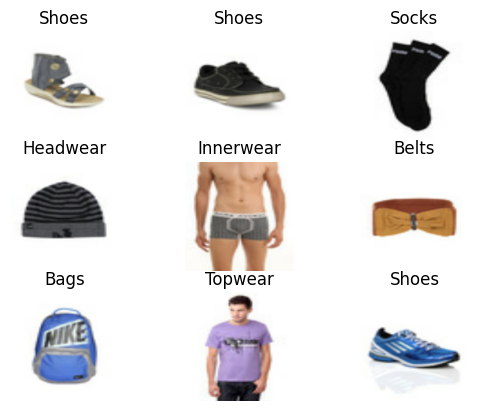

In [ ]:
# Preview dataset images
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# Setup prefecth
train_ds = train_ds.prefetch(8)
val_ds = val_ds.prefetch(8)

class_weights = load_class_weights('/content/class_weights.csv', class_names)

Loading class weights from /content/class_weights.csv
CSV columns: ['class', 'weight']
Loaded weights for 30 classes


In [ ]:
def AlexNet(num_classes = 30):

    model = Sequential()

    model.add(tf.keras.layers.Rescaling(1./255)),

    # Convolutional layer 1
    model.add(Convolution2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
    model.add(Dropout(0.25))

    # Convolutional layer 2
    model.add(Convolution2D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2, strides=2,  padding='same'))
    model.add(Dropout(0.25))

    # Convolutional layer 3
    model.add(Convolution2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
    model.add(Dropout(0.25))

    # Convolutional layer 4
    model.add(Convolution2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
    model.add(Dropout(0.25))

    # Convolutional layer 5
    model.add(Convolution2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))
    model.add(Dropout(0.25))

    # Flatten layer
    model.add(Flatten())

    # Fully connected layer 1
    model.add(Dense(units=1024, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(units=512, activation='relu'))
    model.add(Dropout(0.25))

    # Output layer
    model.add(Dense(units=num_classes, activation='softmax'))

    return model

In [ ]:
model = AlexNet()

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10,
        class_weight=class_weights)

model.save('/content/gdrive/My Drive/Colab_Models/model_AlexNet.h5')

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


  18/1048 ━━━━━━━━━━━━━━━━━━━━ 7:18:33 26s/step - accuracy: 0.0912 - loss: 13.3692

KeyboardInterrupt: 

In [ ]:
model.load_weights('/content/gdrive/My Drive/Colab_Models/model_AlexNet.h5')

In [ ]:
# Computing the model accuracy on test data
test_loss, test_acc = model.evaluate(val_ds)

print('Test accuracy:', test_acc)

468/468 [==============================] - 26s 55ms/step - loss: 0.3491 - accuracy: 0.9027
Test accuracy: 0.9026784896850586


1/1 [==============================] - 0s 19ms/step


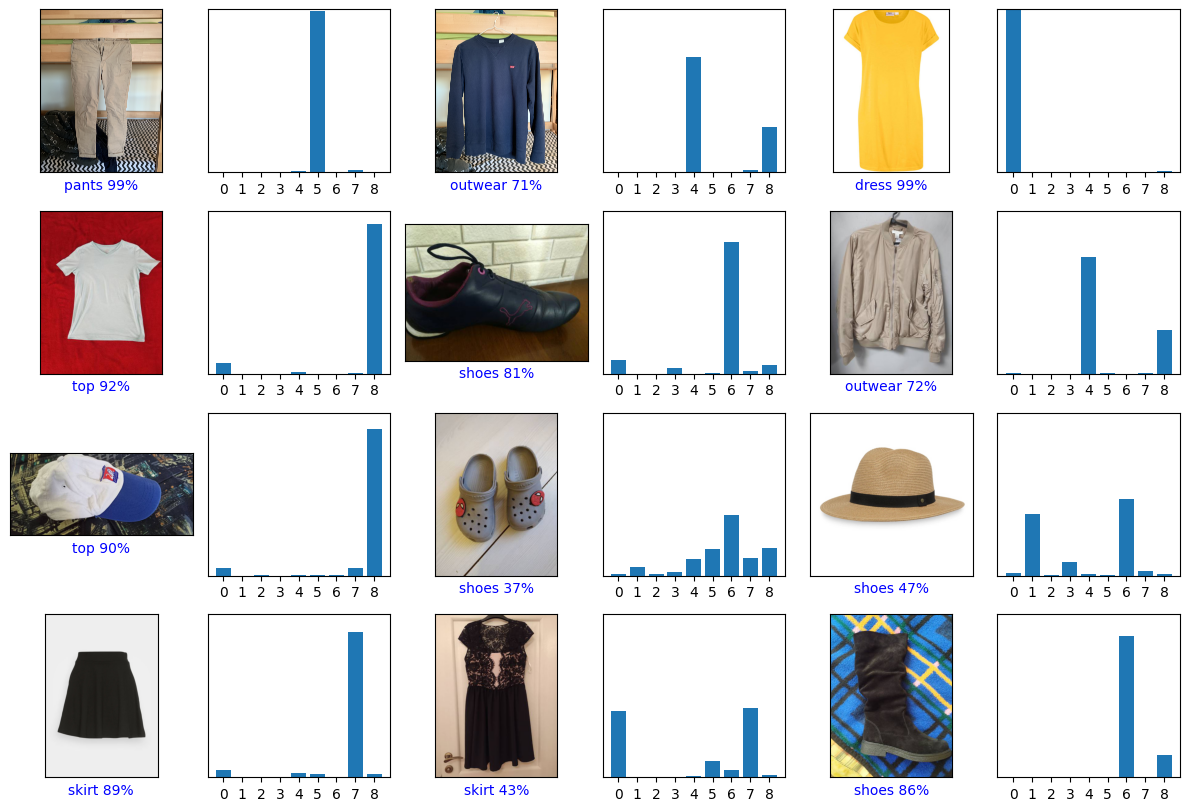

In [ ]:
def plot_image(predictions_array, image):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  img = np.asarray(PIL.Image.open(image))
  plt.imshow(img)

  predicted_label = np.argmax(predictions_array)
  color = 'blue'

  plt.xlabel("{} {:2.0f}%".format(class_names[predicted_label],
                                100*np.max(predictions_array)),
                                color=color)

def plot_value_array(predictions_array):
  plt.grid(False)
  plt.xticks(range(9))
  plt.yticks([])
  thisplot = plt.bar(range(9), predictions_array)
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

img=['shtanina.jpg', 'cofta.jpg', 'dress.jpeg', '1.jpg',
     '2.jpg','3.jpg', '4.jpg', '5.jpg', '6.jpeg', '7.jpeg',  '8.jpg', '9.jpg']

num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(len(img)):
  image = tf.keras.preprocessing.image.load_img(img[i], target_size=(200, 200))
  image = tf.keras.preprocessing.image.img_to_array(image)
  prediction = model.predict(tf.expand_dims(image, 0))[0]
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(prediction, img[i])
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(prediction)
plt.tight_layout()
plt.show()